In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [214]:
import numpy as np
import pandas as pd
import pickle

from dPCA import dPCA

from notebooks.imports import *
from config import dir_config, ephys_config
from src.utils import ephys_utils

In [13]:
compiled_dir = Path(dir_config.data.compiled)
processed_dir = Path(dir_config.data.processed)

In [215]:
session_metadata = pd.read_csv(Path(compiled_dir, "sessions_metadata.csv"))
session_metadata = session_metadata[session_metadata["session_id"] != "241209_GP_TZ"]  # remove session with no trials in biased state coh 6 awayRF choice condition

neuron_metadata = pd.read_csv(Path(compiled_dir, "neuron_metadata.csv"))

with open(Path(processed_dir, "glm_hmm_all_trials_prior_based_initialization_final.pkl"), "rb") as f:
	glm_hmm = pickle.load(f)

with open(Path(processed_dir, "ephys_neuron_wise.pkl"), "rb") as f:
	ephys = pickle.load(f)

## Utils

### Prepare trial-averaged data and trial-wise data

In [19]:
toRF_sessions = session_metadata["session_id"][session_metadata.prior_direction == "toRF"]
awayRF_sessions = session_metadata["session_id"][session_metadata.prior_direction == "awayRF"]

# extract neuron_id for each toRF session
toRF_neuron_ids = np.array([])
for session_id in toRF_sessions:
	neuron_ids = neuron_metadata.neuron_id[neuron_metadata.session_id == session_id].values
	toRF_neuron_ids = np.append(toRF_neuron_ids, neuron_ids)

# extract neuron_id for each awayRF session
awayRF_neuron_ids = np.array([])
for session_id in awayRF_sessions:
	neuron_ids = neuron_metadata.neuron_id[neuron_metadata.session_id == session_id].values
	awayRF_neuron_ids = np.append(awayRF_neuron_ids, neuron_ids)

### Extract biased and unbiased states

In [30]:
state_occupancy = {}
biased_state_trial_info = {}
unbiased_state_trial_info = {}
for idx_session, session_id in enumerate(glm_hmm["session_wise"]["data"]):
	model = glm_hmm["session_wise"]["models"][session_id]
	choices = glm_hmm["session_wise"]["data"][session_id]["choices"].values.reshape(-1, 1)
	input = np.array(glm_hmm["session_wise"]["data"][session_id][["normalized_stimulus", "bias", "previous_choice", "previous_target"]])
	if glm_hmm["session_wise"]["data"][session_id]["mask"] is None:
		mask = None
	else:
		mask = glm_hmm["session_wise"]["data"][session_id]["mask"]
	mask = np.ones_like(choices, dtype=bool) if mask is None else mask

	posterior_probs = model.expected_states(data=choices, input=input, mask=np.array(mask).reshape(-1, 1))[0]
	biased_idx = (posterior_probs[:, 1] > 0.5) & np.array(mask)
	unbiased_idx = (posterior_probs[:, 0] > 0.5) & np.array(mask)
	state_occupancy[session_id] = {"biased_state_trials": glm_hmm["session_wise"]["data"][session_id]["trial_num"][biased_idx], "unbiased_state_trials": glm_hmm["session_wise"]["data"][session_id]["trial_num"][unbiased_idx]}

	biased_state_trials = state_occupancy[session_id]["biased_state_trials"]
	biased_state_trial_info[session_id] = glm_hmm["session_wise"]["data"][session_id].loc[np.isin(glm_hmm["session_wise"]["data"][session_id]["trial_num"], biased_state_trials)]
	unbiased_state_trials = state_occupancy[session_id]["unbiased_state_trials"]
	unbiased_state_trial_info[session_id] = glm_hmm["session_wise"]["data"][session_id].loc[np.isin(glm_hmm["session_wise"]["data"][session_id]["trial_num"], unbiased_state_trials)]

In [ ]:
dpca_trial_averaged_matrix.shape = [N, state_bias, stimulus, choice, timepoints]

In [31]:
condition_dict = {
	"state_values": ["biased", "unbiased"],
	"coherences": [0, 0.06, 0.2, 0.5],
	"choices": ["awayRF", "toRF"],
}

In [ ]:
def create_dpca_matrix(sessions, condition_dict, biased_state_trial_info, unbiased_state_trial_info):
	n_neurons = len(toRF_neuron_ids)
	n_states = len(condition_dict["state_values"])
	n_coherences = len(condition_dict["coherences"])
	n_choices = len(condition_dict["choices"])
	dPCA_averaged_data = {
		event: np.full([n_neurons, n_states, n_coherences, n_choices, ephys_config["alignment_settings_GP"][event]["end_time_ms"] - ephys_config["alignment_settings_GP"][event]["start_time_ms"] + 1], np.nan)
		for event in ephys_config["alignment_settings_GP"].keys()
	}
	dPCA_trial_wise_data = {
		event: np.full([500, n_neurons, n_states, n_coherences, n_choices, ephys_config["alignment_settings_GP"][event]["end_time_ms"] - ephys_config["alignment_settings_GP"][event]["start_time_ms"] + 1], np.nan)
		for event in ephys_config["alignment_settings_GP"].keys()
	}

	for alignment in ephys_config["alignment_settings_GP"].keys():
		for session_id in sessions:
			# get neurons in this session
			neuron_ids = neuron_metadata.neuron_id[neuron_metadata.session_id == session_id].values
			# extract trial numbers for each condition
			for state_idx, state in enumerate(condition_dict["state_values"]):
				if state == "biased":
					trial_info = biased_state_trial_info
				elif state == "unbiased":
					trial_info = unbiased_state_trial_info
				for coherence_idx, coherence in enumerate(condition_dict["coherences"]):
					for choice_idx, choice in enumerate(condition_dict["choices"]):
						trials = ephys_utils.get_trial_num(trial_info[session_id], coherence=coherence, choice=choice_idx, outcome=1)

						for neuron_id in neuron_ids:
							trial_wise_data = ephys_utils.get_neural_data_from_trial_num(ephys[alignment][neuron_id], trials, type="convolved_spike_trains")
							trial_wise_data = trial_wise_data[~np.all(np.isnan(trial_wise_data), axis=1)]
							if trial_wise_data.shape[0] == 0:
								print(f"No trials found in Session: {session_id}, State: {state}, Neuron: {neuron_id}, condition: {coherence, choice}")
								continue
							averaged_data = np.nanmean(trial_wise_data, axis=0)
							dPCA_averaged_data[alignment][np.where(toRF_neuron_ids == neuron_id)[0], state_idx, coherence_idx, choice_idx, :] = averaged_data
							dPCA_trial_wise_data[alignment][: trial_wise_data.shape[0], np.where(toRF_neuron_ids == neuron_id)[0], state_idx, coherence_idx, choice_idx, :] = np.expand_dims(trial_wise_data, axis=1)

	return dPCA_averaged_data, dPCA_trial_wise_data

In [ ]:
dPCA_averaged_data, dPCA_trial_wise_data = create_dpca_matrix(toRF_sessions, condition_dict, biased_state_trial_info, unbiased_state_trial_info)
# remove all columns with any nan in average from timepoins
for alignment in ephys_config["alignment_settings_GP"].keys():
	nonnan_mask = ~np.any(np.isnan(dPCA_averaged_data[alignment]), axis=(0, 1, 2, 3))
	dPCA_averaged_data[alignment] = dPCA_averaged_data[alignment][..., nonnan_mask]
	dPCA_trial_wise_data[alignment] = dPCA_trial_wise_data[alignment][..., nonnan_mask]
	nonnan_trial_mask = ~np.all(np.isnan(dPCA_trial_wise_data[alignment]), axis=(1, 2, 3, 4, 5))
	dPCA_trial_wise_data[alignment] = dPCA_trial_wise_data[alignment][nonnan_trial_mask, ...]

	print(dPCA_averaged_data[alignment].shape)
	print(dPCA_trial_wise_data[alignment].shape)

(87, 2, 4, 2, 501)
(174, 87, 2, 4, 2, 501)
(87, 2, 4, 2, 506)
(174, 87, 2, 4, 2, 506)
(87, 2, 4, 2, 351)
(174, 87, 2, 4, 2, 351)


In [332]:
dpca = dPCA.dPCA(labels="bsct", regularizer=0)  # 4 features: state bias b, stimulus s, choice c, timepoint t
dpca.protect = ["t"]

In [ ]:
alignment = "stimulus_onset"
Z = dpca.fit_transform(dPCA_averaged_data[alignment], dPCA_trial_wise_data[alignment])

#### plot

In [340]:
Z.keys()

dict_keys(['b', 's', 'c', 't', 'bs', 'bc', 'bt', 'sc', 'st', 'ct', 'bsc', 'bst', 'bct', 'sct', 'bsct'])

ValueError: x and y must have same first dimension, but have shapes (250,) and (4, 2, 351)

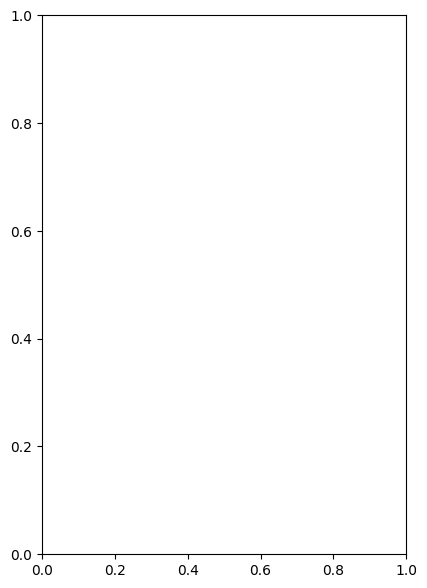

In [ ]:
time = arange(T)

figure(figsize=(16, 7))
subplot(131)

for s in range(S):
	plot(time, Z["t"][0, s])

title("1st time component")

subplot(132)

for s in range(S):
	plot(time, Z["s"][0, s])

title("1st stimulus component")

subplot(133)

for s in range(S):
	plot(time, Z["st"][0, s])

title("1st mixing component")
show()

In [15]:
significance_masks = dpca.significance_analysis(R, trialR, n_shuffles=10, n_splits=10, n_consecutive=10)

Regularization not optimized yet; start optimization now.
Starting trial  1 / 3


AxisError: axis 4 is out of bounds for array of dimension 4

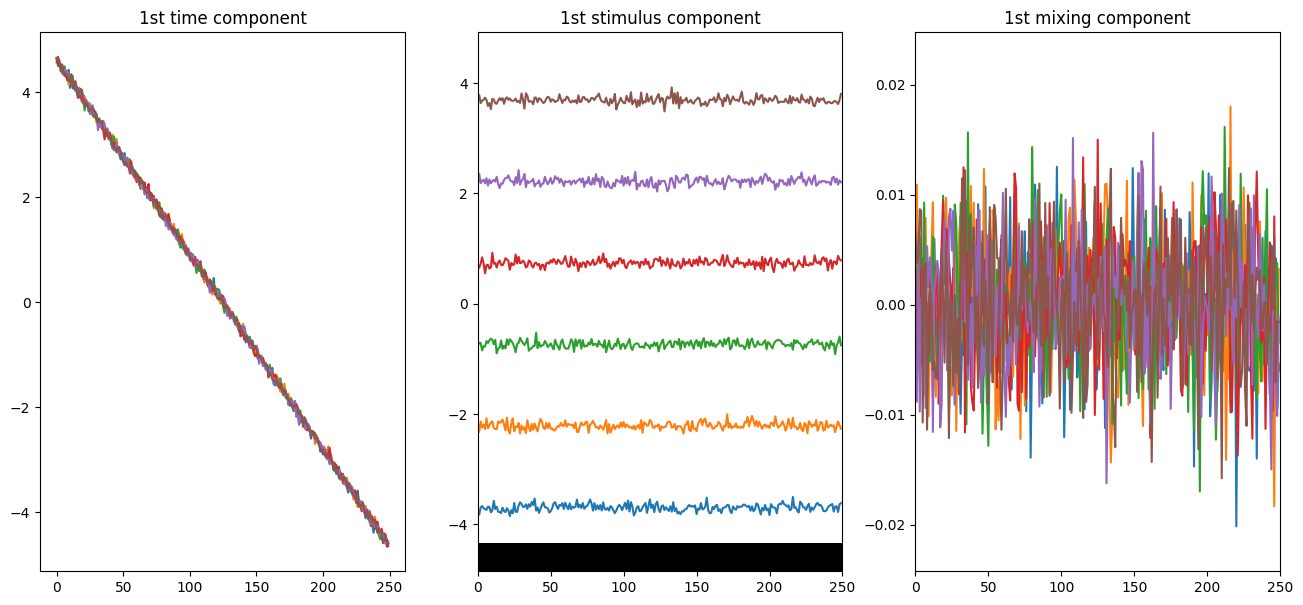

In [10]:
time = arange(T)

figure(figsize=(16, 7))
subplot(131)

for s in range(S):
	plot(time, Z["t"][0, s])

title("1st time component")

subplot(132)

for s in range(S):
	plot(time, Z["s"][0, s])

imshow(significance_masks["s"][0][None, :], extent=[0, 250, amin(Z["s"]) - 1, amin(Z["s"]) - 0.5], aspect="auto", cmap="gray_r", vmin=0, vmax=1)
ylim([amin(Z["s"]) - 1, amax(Z["s"]) + 1])

title("1st stimulus component")

subplot(133)

for s in range(S):
	plot(time, Z["st"][0, s])

dZ = amax(Z["st"]) - amin(Z["st"])
imshow(significance_masks["st"][0][None, :], extent=[0, 250, amin(Z["st"]) - dZ / 10.0, amin(Z["st"]) - dZ / 5.0], aspect="auto", cmap="gray_r", vmin=0, vmax=1)
ylim([amin(Z["st"]) - dZ / 10.0, amax(Z["st"]) + dZ / 10.0])

title("1st mixing component")
show()